## Implementación del Gradient Descent Algorithm para encontrar parámetros de un modelo de regresión logística

Recordemos que un modelo de regresión logística estamos buscando una combinación de variables que modele el log-odds de la siguiente forma,

$$ \text{log} \biggl{(}\frac{P_i}{1-P_i}\biggl{)} = \beta_0 + \sum_{j=1}^{p} \beta_j x_{i,j} $$

Donde $p$ representa la cantidad de variables (columnas, características) en los datos, y $i$ es cada una de las filas, tal que $i \in \{1,\dots,n\}$ con $n$ el tamaño de muestra.

En un modelo de regresión tradicional podemos utilizar métricas como el error cuadrático medio (MSE) o error absoluto medio (MAE) para encontrar los parámetros que minimizan dicha expresión. En el caso de la regresión logística dichas métricas no sirven ya que nuestra variable respuesta tiene la forma $y_i \in \{0,1\}$ considerando un problema de clasificación binomial.

El modelo clásico de regresión logística hace uso de la función logística para modelar las clases / categorías de la variable respuesta, la cual tiene la siguiente forma,

$$ P_i(\beta, x_i) = \frac{1}{1+\text{exp}(-(\beta_0 + \sum_{j=1}^{p})\beta_j x_{i,j})} $$

Para entender la función logística, consideremos una forma sencilla de su expresión,

$$ f(z) = \frac{1}{1+\text{exp}(-z)} $$

Si $z \rightarrow ∞$ entonces $f(z) = 1 $

Si $z → -∞$ entonces $f(z) = 0$

Si $z = 0$ entonces $f(z) = \frac{1}{2}$

## Introduciendo una función de costo

Tal como se mencionó anteriormente, la función de costo asociada al problema de clasificación no puede ser del conjunto de expresiones utilizadas en regresión para respuesta continua, para este caso se introduce el concepto de entropia cruzada (cross-entropy), con esto podemos establecer una métrica que mide qué tanto se equivoca nuestro modelo en el problema de clasificación

$$ Costo = -\frac{1}{n} \sum_{i} y_i\text{log}(\hat{y}_i) + (1-y_i) \text{log}(1-\hat{y}_i) $$

Donde $\hat{y}$ representa los valores predichos por el modelo, considerando:

$$ \hat{y}_i = \Phi(\beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}) $$

$$ \Phi(\hat{y}_i) = \frac{1}{1+\text{exp}(-\hat{y}_i)} $$

Esto nos permite realizar una implementación del algoritmo de gradiente para la estimacion de parámetros. Para simplicidad del ejercicio vamos a trabajar con un dataframe con dos variables $x_1$ y $x_2$ y una respuesta $y \in \{0,1\}$.

Así, las funciones de actualización quedan definidas por:

$$ \beta_j = \beta_j - \alpha \times \biggl{(}\frac{\partial Costo}{\partial \beta_j}\biggl{)}, \forall j \in \{1,2\} $$

$$ \beta_0 = \beta_0 - \alpha \times \biggl{(} \frac{\partial Costo}{\partial \beta_0} \biggl{)} $$

Sin entrar en el detalle matemático (el cual puede ser relativamente complejo ya que se ocupa derivada implicita, regla de la cadena, etc.), las derivadas parciales tienen la siguiente forma,

$$ \frac{\partial Costo}{\partial \beta_j} = (\hat{y} - y) \times x_j $$

$$ \frac{\partial Costo}{\partial \beta_0} = (\hat{y} - y) $$

Lo que nos permite obtener de forma más explicita las funciones de actualización

$$ \beta_1 = \beta_1 - \alpha\times (\hat{y} - y) \times x_1 $$
$$ \beta_2 = \beta_2 - \alpha\times (\hat{y} - y) \times x_2 $$
$$ \beta_0 = \beta_0 - \alpha\times (\hat{y} - y) $$

Notar que esta implementación es generalizable para $p$ variables

## Implementación en R

In [2]:
require(ggplot2)
require(dplyr)

# Simulamos datos para clasificación

# Número de filas en la simulación
n_datos <- 100
df <- data.frame(X1 = c(rnorm(n = n_datos/2, mean = 1, sd = 1),
                        rnorm(n = n_datos/2, mean = 5, sd = 1)),
                 X2 = c(rnorm(n = n_datos/2, mean = 1, sd = 1),
                        rnorm(n = n_datos/2, mean = 5, sd = 1))) %>%
  # Agregamos una columna con 0 y 1 como variable respuesta
  mutate(y = c(rep(0, n_datos/2), rep(1, n_datos/2)))

# Reordenamos los datos
df <- df[sample(1:nrow(df), size = nrow(df)), ]

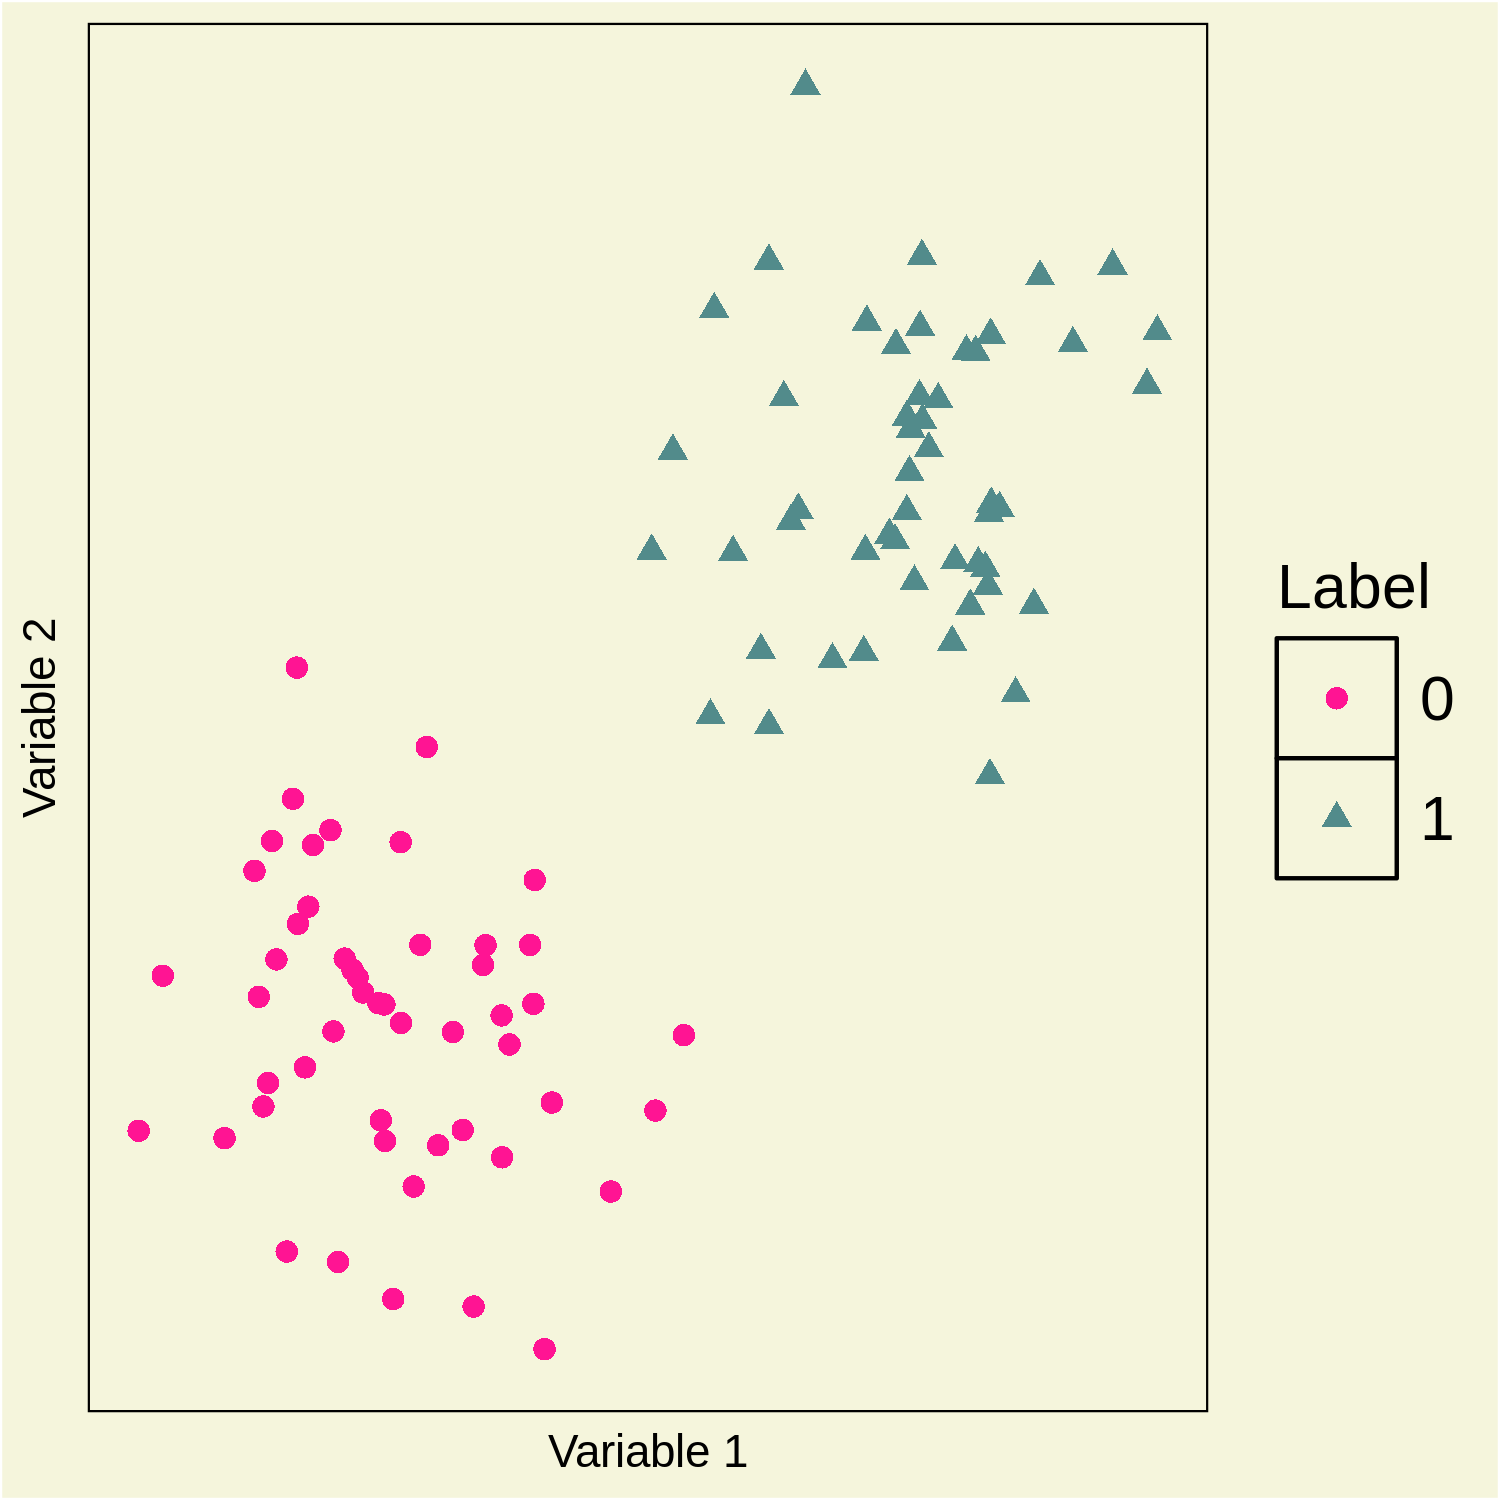

In [3]:
# Opciones de visualizacion
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)

# Visualizacion
df %>%
  # Cambiamos a factor la respuesta
  mutate(Label = as.factor(y)) %>%
  ggplot(aes(x = X1, y = X2, col = Label)) +
  geom_point(aes(shape = Label), size = 2.2) +
  xlab('Variable 1') +
  ylab('Variable 2') +
  # Definimos colores manuales
  scale_color_manual(values = c("deeppink","darkslategray4")) +
  # Definicion de caracteristicas varias del grafico
  theme(panel.background = element_rect(fill = 'beige', colour = 'black'), # Color de fondo
        plot.background = element_rect(fill = 'beige'), # Color de fondo
        legend.background = element_rect(fill = 'beige'), # Color de fondo leyenda
        panel.grid.major = element_blank(), # Eliminamos la grilla
        panel.grid.minor = element_blank(), # Eliminamos la grilla
        axis.text.x = element_blank(), # Eliminamos texto de ejes X e Y
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(), # Eliminamos ticks de los ejes
        axis.ticks.y = element_blank(),
        legend.title = element_text(size = 15), # Tamaño del titulo del grafico
        legend.text = element_text(size = 15), # Tamaño del texto del grafico
        legend.key.size = unit(2,"line") # Tamaño de los simbolos en la leyenda
        )

In [4]:
# Algoritmo

# Ratio de aprendizaje
alpha <- 0.001
# Epocas de entrenamiento
epocas <- 1000

# Definicion inicial de los parametros
beta   = 0
beta_1 = 0
beta_2 = 0

In [5]:
# Vector para guardar los valores de la pendiente y el intercepto
slopes <- rep(NA, epocas)
ints   <- rep(NA, epocas)

betas <- rep(NA, epocas)
betas_1 <- rep(NA, epocas)
betas_2 <- rep(NA, epocas)

for (i in 1:epocas){

  logit <- beta + beta_1 * df$X1 + beta_2 * df$X2
  y <- 1 / (1 + exp(-logit))

  beta <- beta - sum(y - df$y) * alpha
  beta_1 <- beta_1 - sum((y - df$y) * df$X1) * alpha
  beta_2 <- beta_2 - sum((y - df$y) * df$X2) * alpha

  slopes[i] <- -beta_1 / beta_2
  ints[i]   <- -beta / beta_2
  betas[i] <- beta
  betas_1[i] <- beta_1
  betas_2[i] <- beta_2

}

En lo anterior estamos calculando los slopes e interceptos diviendo los coeficientes obtenidos, esto se debe a lo siguiente,

$$ 0 = \beta_0 + \beta_1 x_{1} + \beta_2 x_{2} $$

Si queremos visualizar, tenemos que dejar una de las variables en función de la otra, para este caso despejamos $x_{2}$ en función de $x_{1}$

$$ x_{2} = -\frac{\beta_0}{\beta_2} - \frac{\beta_1}{\beta_2} x_{1} $$

Lo que corresponde a una ecuación de la recta tradicional de la forma $y = mx + b$

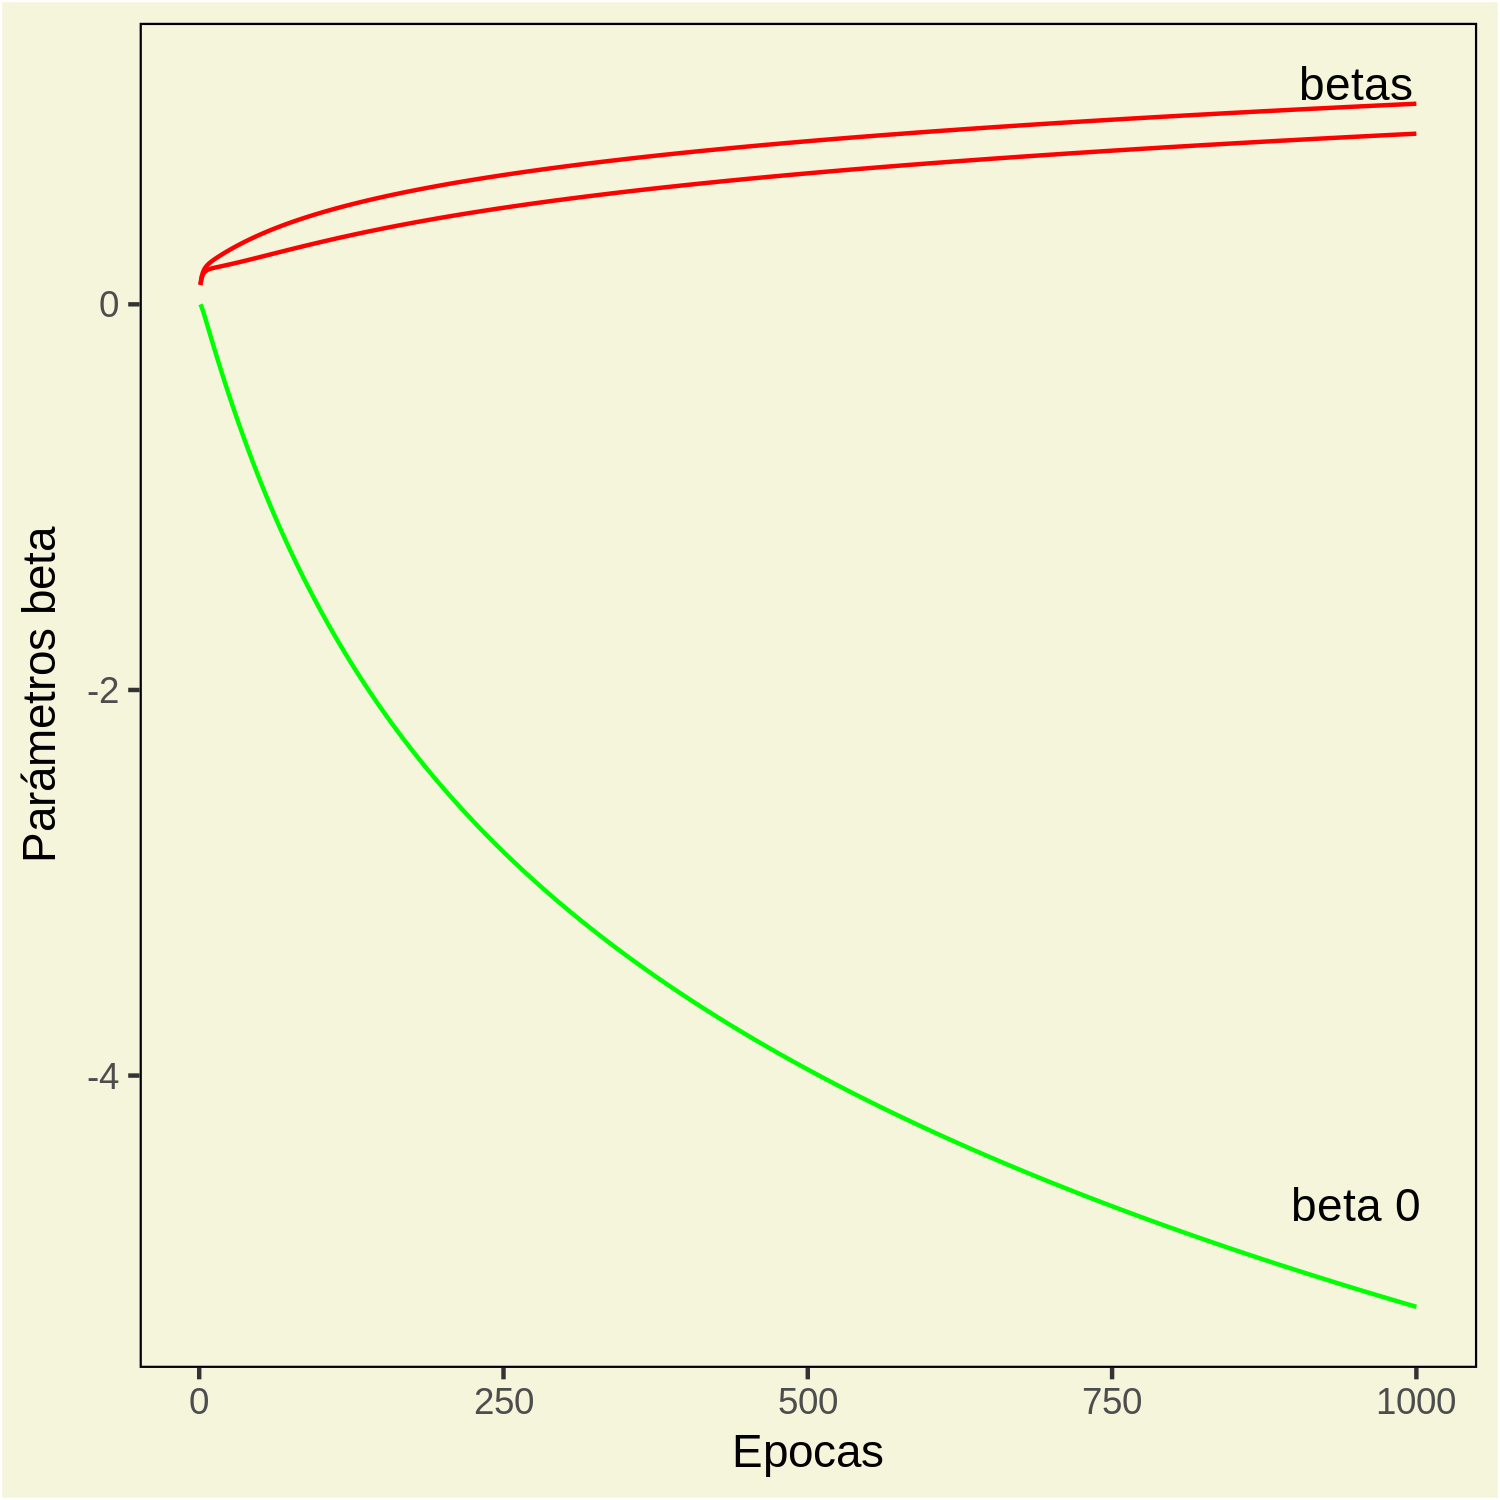

In [6]:
betas_df <- data.frame(n = 1:epocas, beta = betas, beta_1 = betas_1, beta_2 = betas_2)

betas_df %>%
  ggplot(aes(x = n)) +
  geom_line(aes(y = beta), col = 'green') +
  geom_line(aes(y = beta_1), col = 'red') +
  geom_line(aes(y = beta_2), col = 'red') +
  xlab('Epocas') +
  ylab('Parámetros beta') +
  annotate("text", x = tail(epocas)[1] * 0.95, y = tail(betas)[1] * 0.9, label = "beta 0") +
  annotate("text", x = tail(epocas)[1] * 0.95, y = tail(betas_1)[1] * 1.1, label = "betas") +
  theme(panel.background = element_rect(fill = 'beige', colour = 'black'), # Color de fondo
        plot.background = element_rect(fill = 'beige'), # Color de fondo
        legend.background = element_rect(fill = 'beige'), # Color de fondo leyenda
        panel.grid.major = element_blank(), # Eliminamos la grilla
        panel.grid.minor = element_blank(), # Eliminamos la grilla
        legend.title = element_text(size = 15), # Tamaño del titulo del grafico
        legend.text = element_text(size = 15), # Tamaño del texto del grafico
        legend.key.size = unit(2,"line") # Tamaño de los simbolos en la leyenda
        )

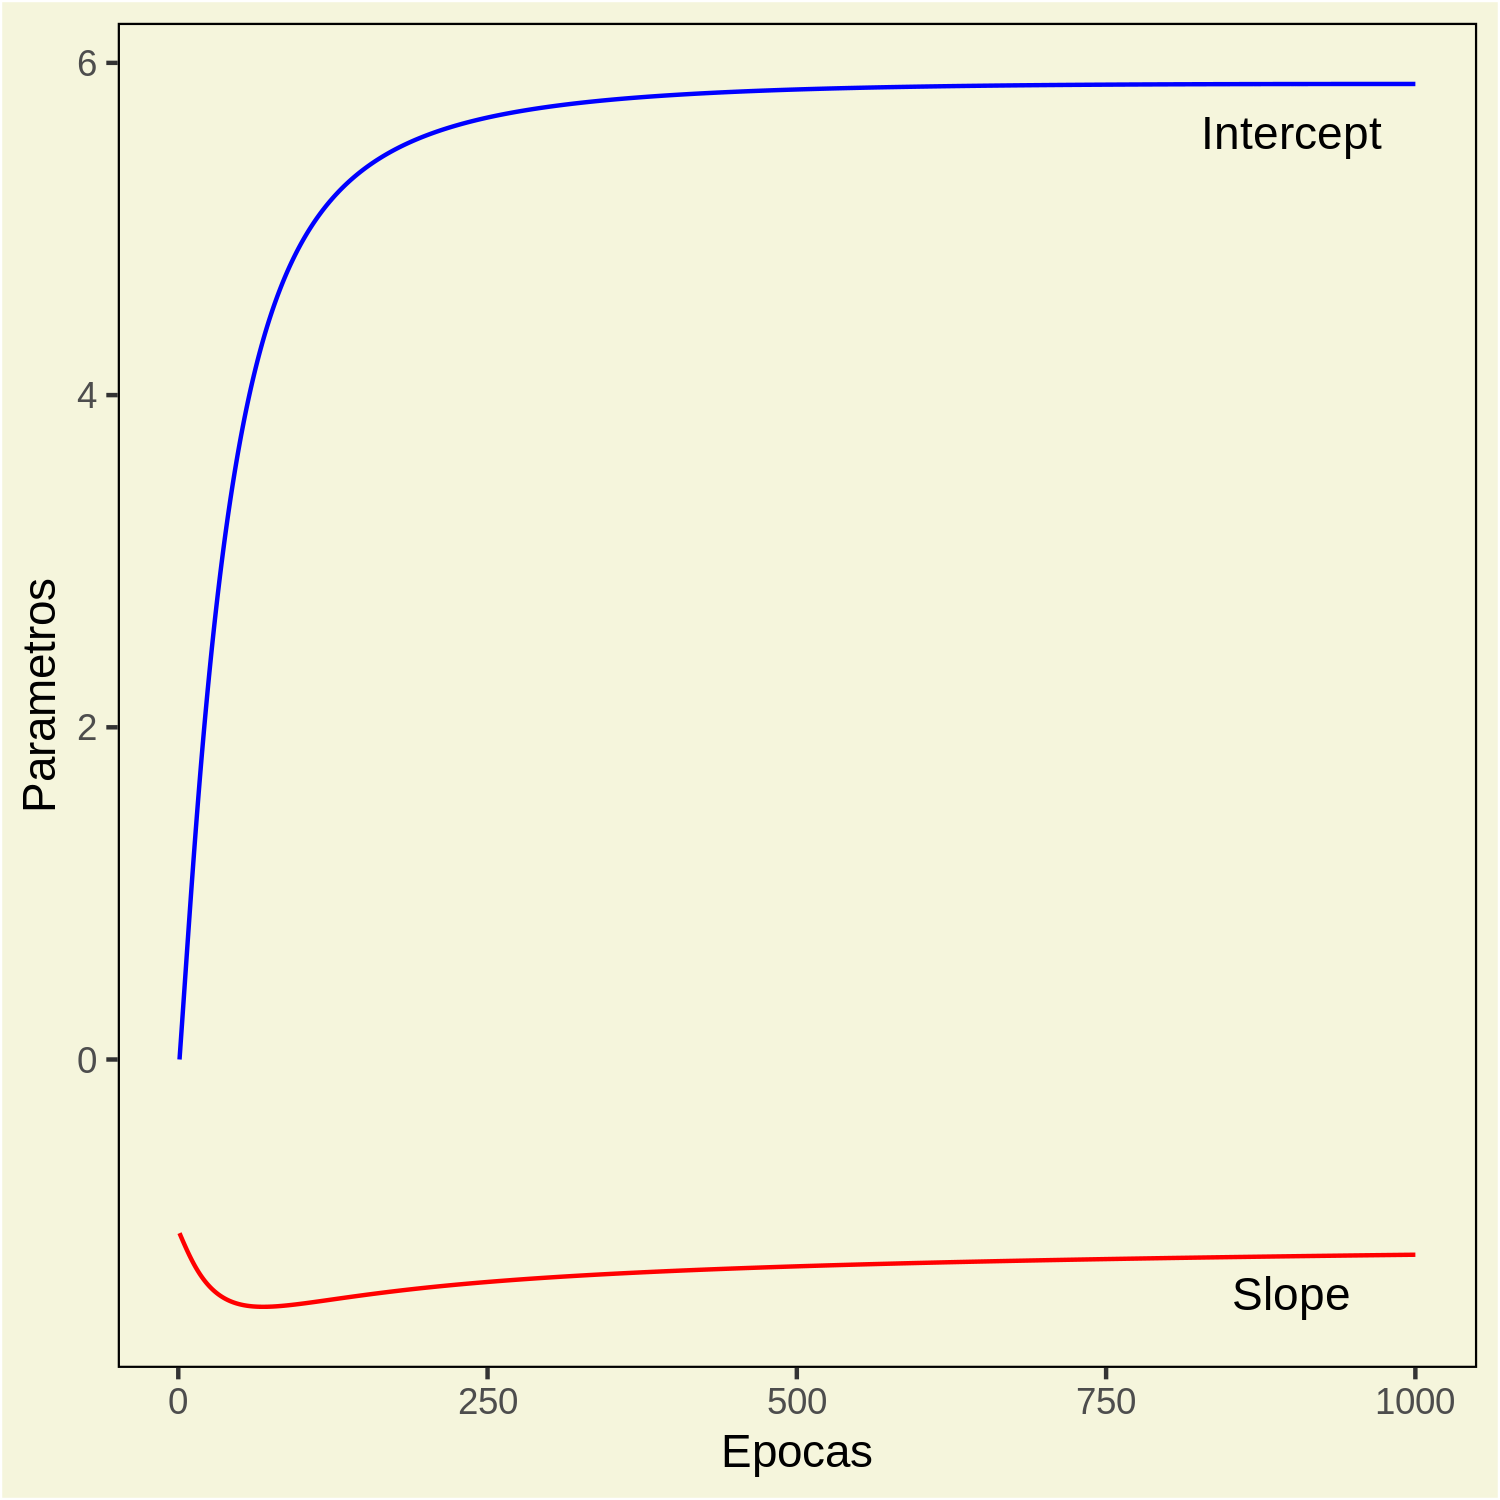

In [7]:
parametros <- data.frame(n = 1:epocas, slopes = slopes, ints = ints)

parametros %>%
  ggplot(aes(x = n)) +
  geom_line(aes(y = slopes), col = 'red') +
  geom_line(aes(y = ints), col = 'blue') +
  xlab('Epocas') +
  ylab('Parametros') +
  annotate("text", x = tail(epocas)[1] * 0.9, y = tail(slopes)[1] * 1.2, label = "Slope") +
  annotate("text", x = tail(epocas)[1] * 0.9, y = tail(ints)[1] * 0.95, label = "Intercept") +
  theme(panel.background = element_rect(fill = 'beige', colour = 'black'), # Color de fondo
        plot.background = element_rect(fill = 'beige'), # Color de fondo
        legend.background = element_rect(fill = 'beige'), # Color de fondo leyenda
        panel.grid.major = element_blank(), # Eliminamos la grilla
        panel.grid.minor = element_blank(), # Eliminamos la grilla
        legend.title = element_text(size = 15), # Tamaño del titulo del grafico
        legend.text = element_text(size = 15), # Tamaño del texto del grafico
        legend.key.size = unit(2,"line") # Tamaño de los simbolos en la leyenda
        )

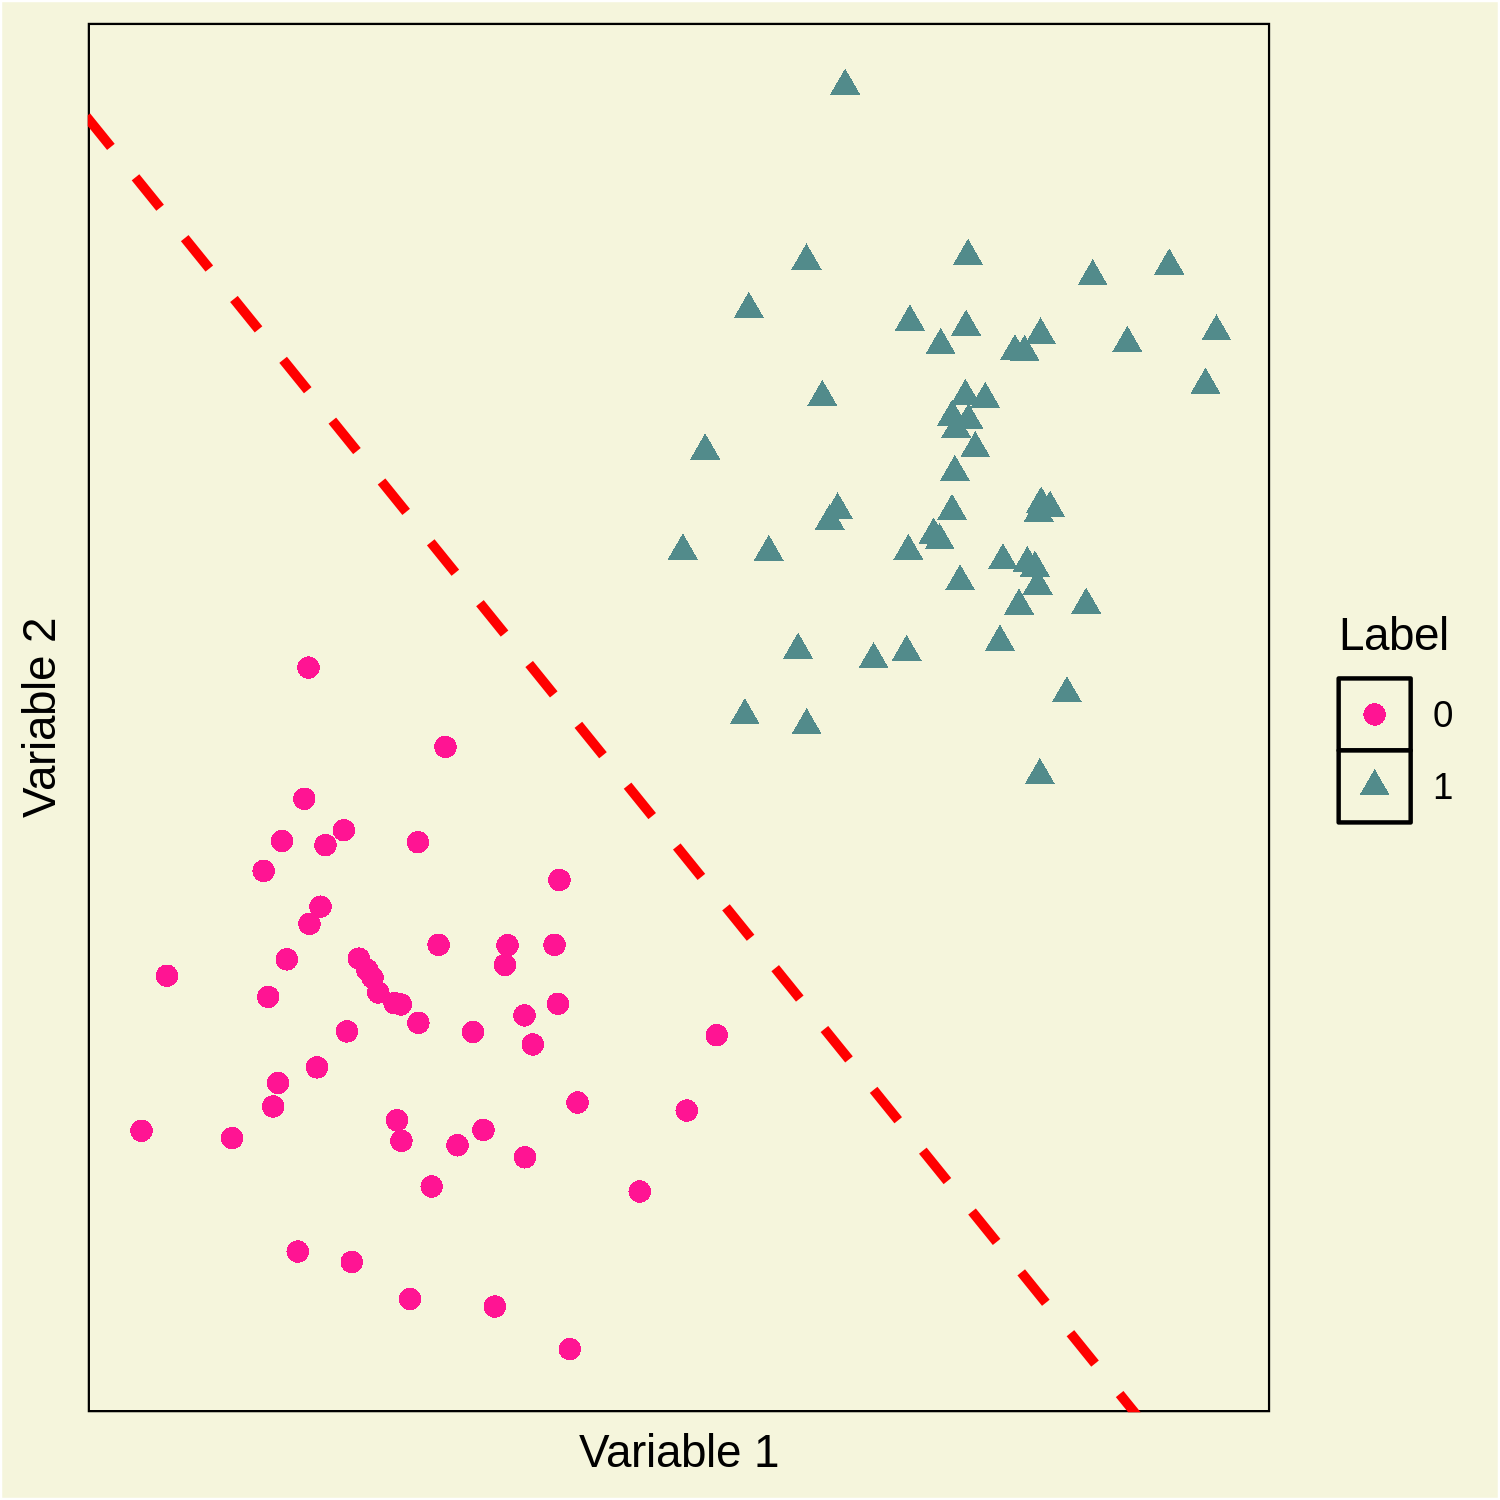

In [9]:
# Ploteamos la regla de clasificacion
df %>%
  mutate(Label = as.factor(y)) %>%
  ggplot(aes(x = X1, y = X2, col = Label)) +
  geom_point(aes(shape = Label), size = 2.2) +
  geom_abline(aes(slope = tail(slopes)[1], intercept = tail(ints)[1]), color = 'red', linetype = 'dashed', size = 1.1) +
  xlab('Variable 1') +
  ylab('Variable 2') +
  scale_color_manual(values = c("deeppink","darkslategray4")) +
  theme(panel.background = element_rect(fill = 'beige', colour = 'black'),
        plot.background = element_rect(fill = 'beige'),
        legend.background = element_rect(fill = 'beige'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank())

## Generación del GIF

Para generar el GIF vamos a tomar un gráfico para distintos valores de los interceptos y pendientes calculados, luego los juntaremos mediante **gifski** y visualizaremos

In [ ]:
# setwd('Acá debería ir tu working directory')

epocas_gif <- seq(from =1, to = epocas, by = 5)
for (i in epocas_gif){

  gg <- df %>%
    mutate(Label = as.factor(y)) %>%
    ggplot(aes(x = X1, y = X2, col = Label)) +
    geom_point(aes(shape = Label), size = 2.2) +
    geom_abline(aes(slope = slopes[i], intercept = ints[i]), color = 'red', linetype = 'dashed', size = 1.1) +
    xlab('Variable 1') +
    ylab('Variable 2') +
    scale_color_manual(values = c("deeppink","darkslategray4")) +
    theme(panel.background = element_rect(fill = 'beige', colour = 'black'),
          plot.background = element_rect(fill = 'beige'),
          legend.background = element_rect(fill = 'beige'),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank())

    ggsave(sprintf("myplot%03d.png", i), gg)

}

In [ ]:
# install.packages(gifski)
require(gifski)

png_files <- Sys.glob("myplot*.png")

gifski(
  png_files,
  'myanimation.gif',
  width = 400, height = 400,
  delay = 1/10
)

In [ ]:
# Eliminamos los archivos png guardados para dejar solo el GIF animado
file.remove(png_files)

Lo anterior entrega un GIF de la siguiente forma, notar cómo se mueve el intercepto y la pendiente de la recta que realiza el corte entre las categorías

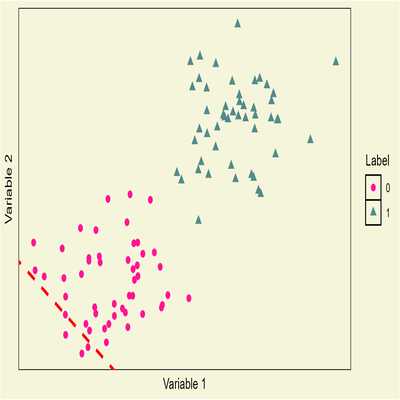

Lo anterior puede ser extendido a más variables, para mantener la visualización añadamos una nueva variable

In [ ]:
# ----------------------------------
# Tres dimensiones -----------------
# ----------------------------------

# Agregamos una nueva variable
df <- df %>% mutate(X3 = c(rnorm(n = n_datos/2, mean = 1, sd = 1),
                           rnorm(n = n_datos/2, mean = 5, sd = 1)))

require(scatterplot3d)

alpha <- 0.001
# Epocas de entrenamiento
epocas <- 1000

# Definicion inicial de los parametros
beta   = 0
beta_1 = 0
beta_2 = 0
beta_3 = 0 # Nuevo parametro dado que tenemos una nueva variable

# Vector para guardar los valores de la pendiente y el intercepto
slopes_1 <- rep(NA, epocas)
slopes_2 <- rep(NA, epocas) # un slope extra
ints     <- rep(NA, epocas)

for (i in 1:epocas){

  logit <- beta + beta_1 * df$X1 + beta_2 * df$X2 + beta_3 * df$X3
  y <- 1 / (1 + exp(-logit))

  beta <- beta - sum(y - df$y) * alpha
  beta_1 <- beta_1 - sum((y - df$y) * df$X1) * alpha
  beta_2 <- beta_2 - sum((y - df$y) * df$X2) * alpha
  beta_3 <- beta_3 - sum((y - df$y) * df$X3) * alpha # Calculo del tercer parametro con actualizacion

  slopes_1[i] <- -beta_1 / beta_3
  slopes_2[i] <- -beta_2 / beta_3
  ints[i]     <- -beta / beta_3

}

aux <- 0
for (i in epocas_gif){

# Dado que vamos a plotear con librerias distintas a ggplot tenemos que hacer ajustes en los graficos
  graphics.off() # Dejamos el graphics.off() para guardar el plot
  png(filename = sprintf("myplot%03d.png", i), width = 8, height = 6, units = "in", res = 300) # Nombre de los archivos a generar
  colors <- c("deeppink","darkslategray4") # Colores para el 3D plot
  colors <- colors[as.factor(df$y)] # Colores como vector
  s3d <- scatterplot3d(df[,c('X1','X2','X3')], # Scatterplot3D con las columnas a plotear
                       color = colors,
                       pch = 16,
                       box = FALSE,
                       # Limites customizados
                       xlim = c(-10,10),
                       ylim = c(-10,10),
                       zlim = c(-10,10),
                       # Angulo que gira dinamicamente
                       angle = 310+aux/5)
# Agregamos el plano con el intercepto y coeficientes
  s3d$plane3d(Intercept = ints[i],
              x.coef = slopes_1[i],
              y.coef = slopes_2[i], lty = 'dashed', lty.box = 'solid')
  dev.off()
  aux <- aux + 1

}

png_files <- Sys.glob("myplot*.png")

gifski(
  png_files,
  'myanimation_3D.gif',
  width = 400, height = 400,
  delay = 1/10
)
file.remove(png_files)

Lo anterior genera el GIF mostrando cómo se ajustan los parámetros de la regresión logística considerando las tres variables $x_1, x_2, x_3$. De forma similar al plot en 3D tenemos que ajustar el plano generado mediante lo siguiente,

$$ x_3 = -\frac{\beta_0}{\beta_3} -\frac{\beta_1}{\beta_3} x_1 - \frac{\beta_2}{\beta_3}x_3 $$

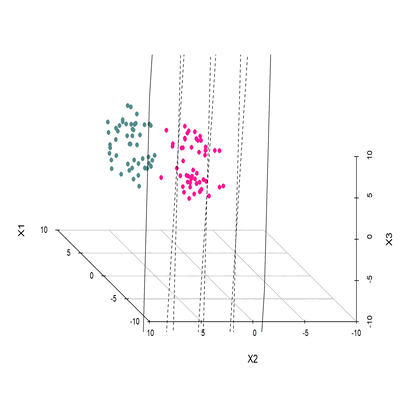